## Let's test some metrics

In [6]:
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import chillmax as cm

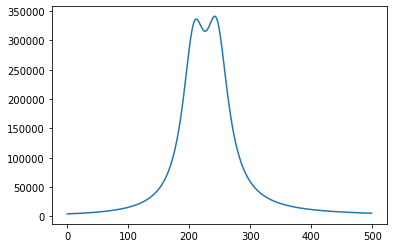

In [15]:
def from_jld(i):
    import h5py
    f = h5py.File('datasets/frequency_scaling_{}_{}.jld2'.format(18+i, 19+i), 'r')
    return f['spacs'][()]
    
cfg = from_jld(0)[0]
peak = cm.sim.boost(np.linspace(18.01, 18.03, 500), spacings=cfg)
double_peak = peak + cm.sim.boost(np.linspace(18.0085, 18.0285, 500), spacings=cfg)
plt.plot(double_peak)

In [45]:
def metric_test(fcn, name="Metric", decim=3, real=True):
    '''
    Make x-check plots for some metric `fcn`
    '''
    if not real: 
        N = 50
        base = np.ones(N)
        base[int(N/2-N/6):int(N/2+N/6)] = 100

        fig, axs = plt.subplots(2,2, figsize=(12,12))
        axs = axs.flatten()
        for ax in axs:
            ax.plot(base, label="Base", c='black')

        cmap = sns.cubehelix_palette(8)
        for i, sh in enumerate(range(-12, 12, 4)):
            temp = np.ones_like(base)
            if sh < 0:
                temp[:-abs(sh)] = base[abs(sh):]
            else:
                temp[sh:] = base[:len(temp[sh:])]
            axs[0].plot(temp, label='Shift {}, $\Delta${} = {}'.format(sh, name, str(round(fcn(base, temp), decim))),
                    color=cmap[i], ls='--')
            axs[0].legend()
            axs[0].set_title('Shift')
            axs[0].set_xlim(0, 70)

        cmap = sns.cubehelix_palette(8, start=.5, rot=-.75)
        for i, sc in enumerate(np.linspace(0.3, 1.7, 5)):
            temp = base * sc
            axs[1].plot(temp, label='Scale {}, $\Delta${} = {}'.format(round(sc,2), name, str(round(fcn(base, temp), decim))),
                    color=cmap[i], ls=':')
            axs[1].legend()
            axs[1].set_title('Up/Down')
            axs[1].set_xlim(0, 70)

        cmap = sns.cubehelix_palette(8)
        for i, sc in enumerate(range(4, 16, 2)):
            temp = np.ones_like(base)
            temp[int(len(temp)/2)-sc: int(len(temp)//2)+sc] = 100

            axs[2].plot(temp, label='Width {}, $\Delta${} = {}'.format(round(2*sc,2), name, str(round(fcn(base, temp), decim))),
                        color=cmap[i], ls=':')
            axs[2].legend()
            axs[2].set_title('Wider/Slimmer')
            axs[2].set_xlim(0, 70)


        def line(pts, k, m):
            return pts * k - m    

        cmap = sns.cubehelix_palette(8, start=.1, rot=-.15)
        for i, sc in enumerate(range(-6, 6, 2)):
            temp = np.zeros_like(base)
            temp[int(N/2-N/6):int(N/2+N/6)] = 100+line(np.arange(-7, 10), sc, 0)

            axs[3].plot(temp, label='Slope {}, $\Delta${} = {}'.format(round(sc,2), name, str(round(fcn(base, temp), decim))),
                        color=cmap[i], ls=':')
            axs[3].legend()
            axs[3].set_title('Reshape')
            axs[3].set_xlim(0, 70)
    else:
        fig, axs = plt.subplots(2,1, figsize=(12,12))
        axs = axs.flatten()
        
        cfg = from_jld(0)[0]
        peak = cm.sim.boost(np.linspace(18.01, 18.03, 500), spacings=cfg)
        double_peak = peak + cm.sim.boost(np.linspace(18.0085, 18.0285, 500), spacings=cfg)
        
        for ax in axs[:1]:
            ax.plot(peak, label="Base", c='black')

        # Peak shifts
        cmap = sns.cubehelix_palette(8)
        for i, sh in enumerate(range(-12, 12, 4)):
            _scale = 0.0002
            temp = cm.sim.boost(np.linspace(18.01+sh*_scale, 18.03+sh*_scale, 500), spacings=cfg) * (1+0.01*sh)
            axs[0].plot(temp, label='Shift {}, $\Delta${} = {}'.format(sh, name, str(round(fcn(peak, temp), decim))),
                    color=cmap[i], ls='--')
            axs[0].legend()
            axs[0].set_title('Shift and Scale')
            #axs[0].set_xlim(50, 600)
        
        axs[1].plot(double_peak, label="Base", c='black')
        cmap = sns.cubehelix_palette(8)
        for i, sh in enumerate(np.r_[np.arange(-11, 12, 4), [30]]):
            _scale = 0.0002
            temp = peak+cm.sim.boost(np.linspace(18.01+sh*_scale, 18.03+sh*_scale, 500), spacings=cfg)
            axs[1].plot(temp, label='Shift {}, $\Delta${} = {}'.format(sh, name, str(round(fcn(double_peak, temp), decim))),
                    color=cmap[i], ls='--')
            axs[1].legend()
            axs[1].set_title('Combined Peak')
            

### Jensen-Shannon
 - symmetric
 - normalizing
   - good for comparing shapes, but not magnitude

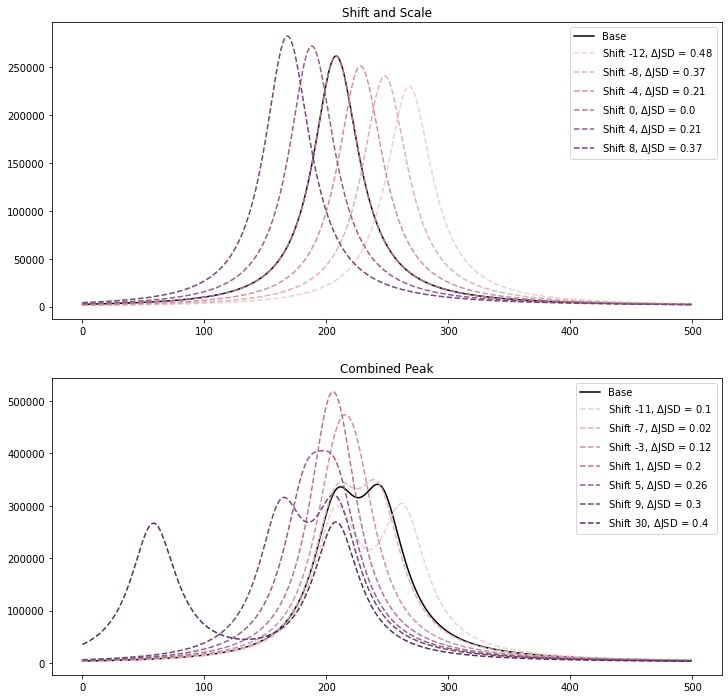

In [46]:
from scipy.spatial.distance import jensenshannon as jsd
metric_test(jsd, name="JSD", decim=2)

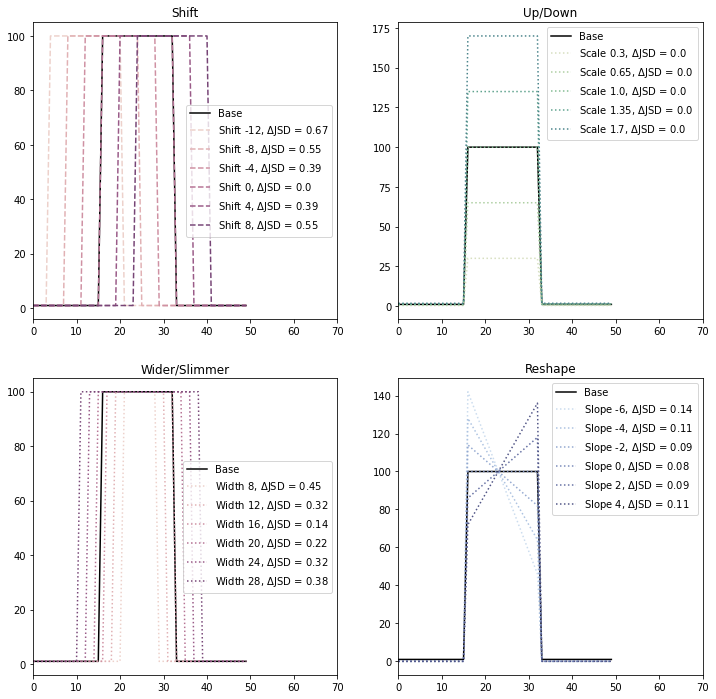

In [47]:
metric_test(jsd, name="JSD", decim=2, real=False)

### FWHM

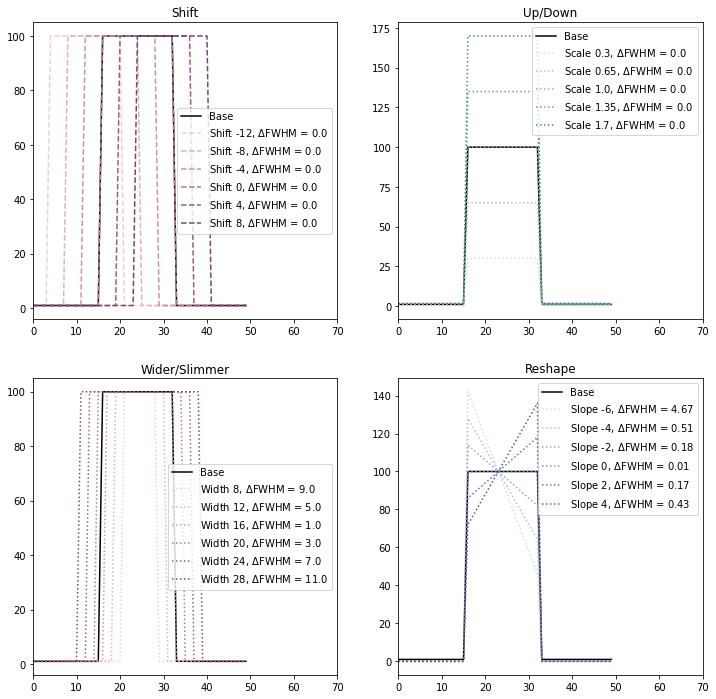

In [50]:
from scipy.interpolate import splrep, sproot, splev

# Steal from stack-overflow https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak
class MultiplePeaks(Exception): pass
class NoPeaksFound(Exception): pass
def fwhm(x, y, k=3):
    """
    Determine full-with-half-maximum of a peaked set of points, x and y.

    Assumes that there is only one peak present in the datasset.  The function
    uses a spline interpolation of order k.
    """

    half_max = np.amax(y)/2.0
    s = splrep(x, y - half_max, k=k)
    roots = sproot(s)

    if len(roots) > 2:
        raise MultiplePeaks("The dataset appears to have multiple peaks, and "
                "thus the FWHM can't be determined.")
    elif len(roots) < 2:
        raise NoPeaksFound("No proper peaks were found in the data set; likely "
                "the dataset is flat (e.g. all zeros).")
    else:
        return abs(roots[1] - roots[0])
    
# Make it into a metric
def fwhm_metric(true, pred):
    return np.abs(fwhm(np.arange(len(true)), true) - fwhm(np.arange(len(pred)), pred))
    
metric_test(fwhm_metric, name="FWHM", decim=2, real=False)

- behaves as expected
  - Shift and up/down scaling don't change width, so there is no difference to base value
- should be more crafty with more than one peak, but this should be a good measure

## Peak position

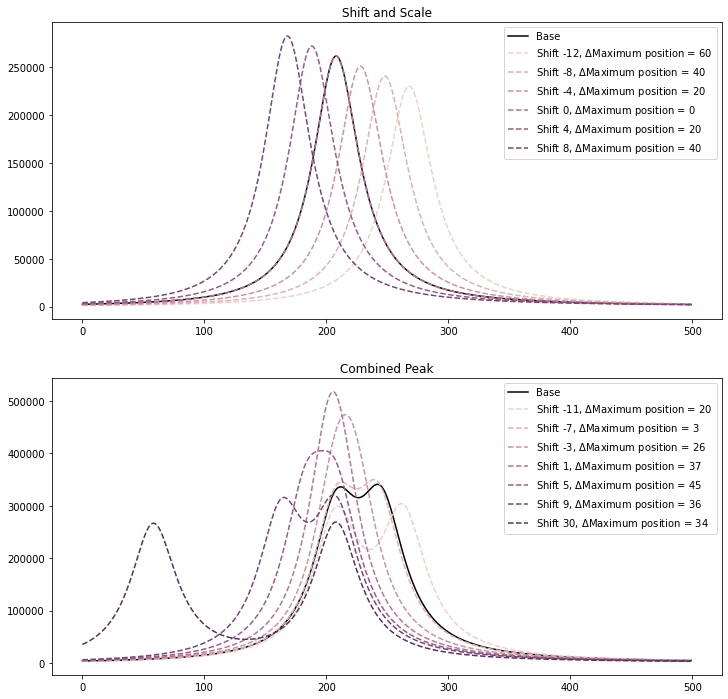

In [63]:
def peak_pos(a, b):
    return abs(np.argmax(np.array(a).astype(float)) - np.argmax(np.array(b).astype(float)))

metric_test(peak_pos, name="Maximum position", decim=2)

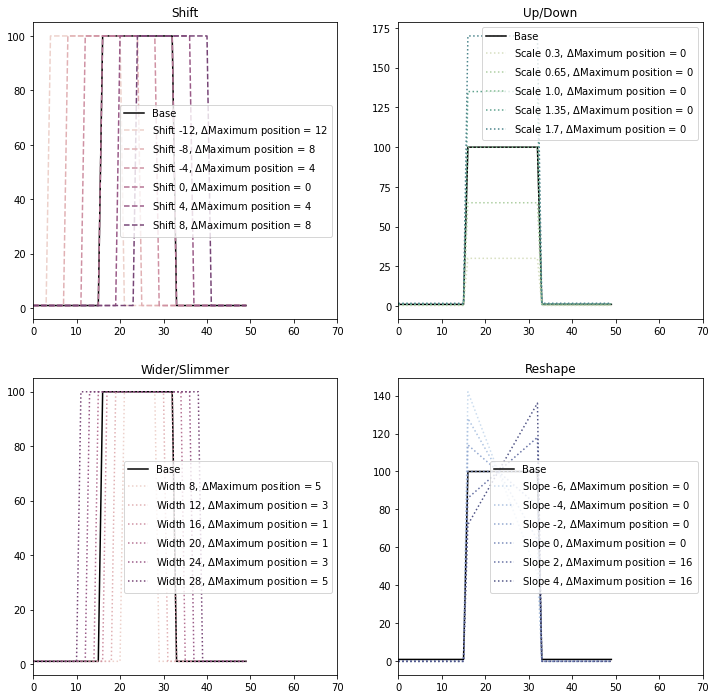

In [65]:
metric_test(peak_pos, name="Maximum position", decim=2, real=False)